
# Silent Signals: Environmental & Socioeconomic Drivers in Cancer Malignancy Prediction — Full Notebook (Updated)

This Jupyter notebook implements the complete pipeline for your final project.

**Goal:** Evaluate whether adding environmental (PM2.5, adult smoking) and socioeconomic
(income, uninsured rate, primary-care access) context to classic tumor features improves
machine-learning prediction of cancer malignancy (malignant = 1, benign = 0).

**Sections:**

1. Setup: imports & paths.  
2. Load & display raw datasets.  
3. Merge, clean, and engineer features.  
4. Visual exploration (distributions & boxplots).  
5. Modeling helpers (LR, RF, optional XGB).  
6. Baseline vs extended models.  
7. Metrics JSON export.  
8. Simple ablation (Tumor vs Env vs Socio vs Extended).  
9. Seed sensitivity (robustness).  
10. Interpretation, limitations, ethics & reproducibility (notes).



## 1. Setup: Imports & Paths

> 🔧 **Edit `BASE_DIR` below** so it points to the folder on your PC where the datasets live.

Expected structure (you can adjust):

```text
C:\Users\tafis\Downloads\Cancer M\
    datasets\
        env_counties_updated.csv
        tumor_patients_updated.csv
    outputs\
        (this notebook will create files here)
```


In [1]:

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Try XGBoost if installed (optional)
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# %matplotlib inline  # uncomment in classic Jupyter

# === EDIT THIS TO MATCH YOUR PC FOLDER ===
BASE_DIR = r"C:\Users\tafis\Downloads\Cancer M"  # change if needed

DATASETS_DIR = os.path.join(BASE_DIR, "datasets")
OUTPUTS_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUTPUTS_DIR, exist_ok=True)

# Filenames (rename here if you kept original names)
ENV_FILENAME = "env_counties_updated.csv"
PTS_FILENAME = "tumor_patients_updated.csv"

print("BASE_DIR     :", BASE_DIR)
print("DATASETS_DIR :", DATASETS_DIR)
print("OUTPUTS_DIR  :", OUTPUTS_DIR)
print("XGBoost available? ->", HAS_XGB)


BASE_DIR     : C:\Users\tafis\Downloads\Cancer M
DATASETS_DIR : C:\Users\tafis\Downloads\Cancer M\datasets
OUTPUTS_DIR  : C:\Users\tafis\Downloads\Cancer M\outputs
XGBoost available? -> False



## 2. Data & Methods (Conceptual Overview)

- **Tumor dataset – `tumor_patients_updated.csv`**  
  Breast cancer–style tumor features (radius, texture, smoothness, perimeter, area,
  compactness, concavity, concave points, symmetry, fractal dimension) plus a binary
  label `malignant` (1 = malignant, 0 = benign).

- **Environment & socioeconomic dataset – `env_counties_updated.csv`**  
  County-level context variables:
  - `pm25`: fine particulate matter (air pollution).  
  - `adult_smoking_pct`: adult smoking percentage.  
  - `median_income`: median household income.  
  - `uninsured_pct`: percentage of adults without health insurance.  
  - `pcp_per_1k`: primary-care physicians per 1,000 population.

- **Synthetic linkage**  
  Each patient is linked to a county using a synthetic mapping so that tumor rows can be
  joined with county-level exposures while preserving privacy.

### Composite indices

We compress correlated context variables into two summary indices:

- Environmental index:  
  `env_index = z(pm25) + z(adult_smoking_pct)`

- Socioeconomic index:  
  `socio_index = z(median_income) + z(pcp_per_1k) − z(uninsured_pct)`



## 3. Load Data from Local PC & Display Raw Tables

This cell:

- Reads the two CSV files from your **local** machine.  
- Prints shapes (`.shape`).  
- Shows the first few rows (`head()`).  
- Displays schema information (`info()`).


In [3]:

# Paths to CSV files
env_path = os.path.join(DATASETS_DIR, ENV_FILENAME)
pts_path = os.path.join(DATASETS_DIR, PTS_FILENAME)

print("[Load] Reading CSV files...")
print(" - Environment file:", env_path)
print(" - Tumor file      :", pts_path)

env = pd.read_csv(env_path)
pts = pd.read_csv(pts_path)

print("\n[Load] Shapes:")
print(" env_counties   :", env.shape)
print(" tumor_patients :", pts.shape)

print("\n[Load] env_counties – head():")
display(env.head())

print("\n[Load] tumor_patients – head():")
display(pts.head())

print("\n[Load] env_counties – info():")
display(env.info())

print("\n[Load] tumor_patients – info():")
display(pts.info())


[Load] Reading CSV files...
 - Environment file: C:\Users\tafis\Downloads\Cancer M\datasets\env_counties_updated.csv
 - Tumor file      : C:\Users\tafis\Downloads\Cancer M\datasets\tumor_patients_updated.csv

[Load] Shapes:
 env_counties   : (50, 7)
 tumor_patients : (2000, 13)

[Load] env_counties – head():


,county,population,pm25,adult_smoking_pct,median_income,uninsured_pct,pcp_per_1k
0,County_01,758678,9.02,19.09,46747.0,8.15,0.971
1,County_02,518821,8.76,18.63,50994.0,6.62,1.182
2,County_03,563134,10.98,17.25,52994.0,8.37,1.759
3,County_04,722910,10.71,8.00,52574.0,6.87,0.703
4,County_05,483719,10.21,15.85,40974.0,8.33,1.315



[Load] tumor_patients – head():


,patient_id,county,radius_mean,texture_mean,smoothness_mean,perimeter_mean,area_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,malignant
0,P100000,County_13,10.582778,18.626033,0.085718,106.438207,678.922125,0.137063,0.071841,0.044970,0.212078,0.069742,0
1,P100001,County_08,14.409065,30.297735,0.093655,90.225932,685.257503,0.183839,0.081329,0.038569,0.153498,0.045545,1
2,P100002,County_07,15.580309,16.165761,0.143104,101.573870,920.382664,0.168944,0.142855,0.053404,0.192796,0.059408,1
3,P100003,County_05,11.097976,24.536686,0.104135,44.768488,813.393648,0.127810,0.122482,0.033794,0.162557,0.062339,1
4,P100004,County_05,8.238191,18.790615,0.118694,72.403668,449.595689,0.090492,0.008988,0.082113,0.176764,0.067241,0



[Load] env_counties – info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county             50 non-null     object 
 1   population         50 non-null     int64  
 2   pm25               50 non-null     float64
 3   adult_smoking_pct  50 non-null     float64
 4   median_income      50 non-null     float64
 5   uninsured_pct      50 non-null     float64
 6   pcp_per_1k         50 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 2.9+ KB


None


[Load] tumor_patients – info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   patient_id              2000 non-null   object 
 1   county                  2000 non-null   object 
 2   radius_mean             2000 non-null   float64
 3   texture_mean            2000 non-null   float64
 4   smoothness_mean         2000 non-null   float64
 5   perimeter_mean          2000 non-null   float64
 6   area_mean               2000 non-null   float64
 7   compactness_mean        2000 non-null   float64
 8   concavity_mean          2000 non-null   float64
 9   concave_points_mean     2000 non-null   float64
 10  symmetry_mean           2000 non-null   float64
 11  fractal_dimension_mean  2000 non-null   float64
 12  malignant               2000 non-null   int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 203.3+ KB


None


## 4. Merge, Clean, and Engineer Features

Steps:

1. Merge `pts` (tumor) with `env` (environment) on `county`.  
2. Convert key columns to numeric and impute missing values with medians.  
3. Compute `env_index` and `socio_index`.  
4. Build multiple feature sets for modeling:
   - `X_tumor`: tumor-only.  
   - `X_env`: environment-only + `env_index`.  
   - `X_socio`: socioeconomic-only + `socio_index`.  
   - `X_ext`: full extended feature set (tumor + env + socio + indices).


In [5]:

from sklearn.preprocessing import StandardScaler

print("[Merge] Joining patients with county-level environment on 'county'...")
df = pts.merge(env, on="county", how="left")
print("Merged shape:", df.shape)
display(df.head())

# Define column groups
tumor_cols = [
    "radius_mean", "texture_mean", "smoothness_mean", "perimeter_mean", "area_mean",
    "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean",
    "fractal_dimension_mean",
]

env_base_cols = ["pm25", "adult_smoking_pct"]
socio_base_cols = ["median_income", "uninsured_pct", "pcp_per_1k"]

# Convert to numeric and impute with medians
for col in tumor_cols + env_base_cols + socio_base_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df[tumor_cols + env_base_cols + socio_base_cols] = df[
    tumor_cols + env_base_cols + socio_base_cols
].fillna(df[tumor_cols + env_base_cols + socio_base_cols].median())

# Build standardized versions for indices
scaler_env = StandardScaler()
scaler_socio = StandardScaler()

df_env_std = scaler_env.fit_transform(df[env_base_cols])
df_socio_std = scaler_socio.fit_transform(df[socio_base_cols])

df["env_index"] = df_env_std[:, 0] + df_env_std[:, 1]

median_income_z = df_socio_std[:, socio_base_cols.index("median_income")]
pcp_z           = df_socio_std[:, socio_base_cols.index("pcp_per_1k")]
uninsured_z     = df_socio_std[:, socio_base_cols.index("uninsured_pct")]

df["socio_index"] = median_income_z + pcp_z - uninsured_z

print("\n[Feature Engineering] env_index & socio_index added:")
display(
    df[[
        "county", "pm25", "adult_smoking_pct", "env_index",
        "median_income", "uninsured_pct", "pcp_per_1k", "socio_index"
    ]].head()
)

# Build feature matrices and target
y = df["malignant"].astype(int).values

X_tumor = df[tumor_cols].copy()
X_env   = df[env_base_cols + ["env_index"]].copy()
X_socio = df[socio_base_cols + ["socio_index"]].copy()
X_ext   = df[tumor_cols + env_base_cols + socio_base_cols + ["env_index", "socio_index"]].copy()

print("\n[Features] Shapes:")
print(" X_tumor:", X_tumor.shape)
print(" X_env  :", X_env.shape)
print(" X_socio:", X_socio.shape)
print(" X_ext  :", X_ext.shape)


[Merge] Joining patients with county-level environment on 'county'...
Merged shape: (2000, 19)


,patient_id,county,radius_mean,texture_mean,smoothness_mean,perimeter_mean,area_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,malignant,population,pm25,adult_smoking_pct,median_income,uninsured_pct,pcp_per_1k
0,P100000,County_13,10.582778,18.626033,0.085718,106.438207,678.922125,0.137063,0.071841,0.044970,0.212078,0.069742,0,734467,6.32,14.77,58860.0,6.61,1.329
1,P100001,County_08,14.409065,30.297735,0.093655,90.225932,685.257503,0.183839,0.081329,0.038569,0.153498,0.045545,1,218905,11.39,11.88,38075.0,7.41,1.776
2,P100002,County_07,15.580309,16.165761,0.143104,101.573870,920.382664,0.168944,0.142855,0.053404,0.192796,0.059408,1,675238,9.94,18.45,64229.0,5.65,2.003
3,P100003,County_05,11.097976,24.536686,0.104135,44.768488,813.393648,0.127810,0.122482,0.033794,0.162557,0.062339,1,483719,10.21,15.85,40974.0,8.33,1.315
4,P100004,County_05,8.238191,18.790615,0.118694,72.403668,449.595689,0.090492,0.008988,0.082113,0.176764,0.067241,0,483719,10.21,15.85,40974.0,8.33,1.315



[Feature Engineering] env_index & socio_index added:


,county,pm25,adult_smoking_pct,env_index,median_income,uninsured_pct,pcp_per_1k,socio_index
0,County_13,6.32,14.77,-1.937030,58860.0,6.61,1.329,1.042566
1,County_08,11.39,11.88,0.305143,38075.0,7.41,1.776,-0.963646
2,County_07,9.94,18.45,1.143643,64229.0,5.65,2.003,4.110834
3,County_05,10.21,15.85,0.632834,40974.0,8.33,1.315,-2.414770
4,County_05,10.21,15.85,0.632834,40974.0,8.33,1.315,-2.414770



[Features] Shapes:
 X_tumor: (2000, 10)
 X_env  : (2000, 3)
 X_socio: (2000, 4)
 X_ext  : (2000, 17)



## 5. Cleaning Summary & Visual Exploration

Here we:

- Check remaining missing values in the extended feature matrix.  
- Plot distributions for `radius_mean` and `pm25`.  
- Plot boxplots of:
  - PM2.5 by malignancy status.  
  - Adult smoking % by malignancy status.  
  - `env_index` and `socio_index` by malignancy status.


[Cleaning] Remaining missing values in X_ext:


radius_mean               0
texture_mean              0
smoothness_mean           0
perimeter_mean            0
area_mean                 0
compactness_mean          0
concavity_mean            0
concave_points_mean       0
symmetry_mean             0
fractal_dimension_mean    0
pm25                      0
adult_smoking_pct         0
median_income             0
uninsured_pct             0
pcp_per_1k                0
env_index                 0
socio_index               0
dtype: int64

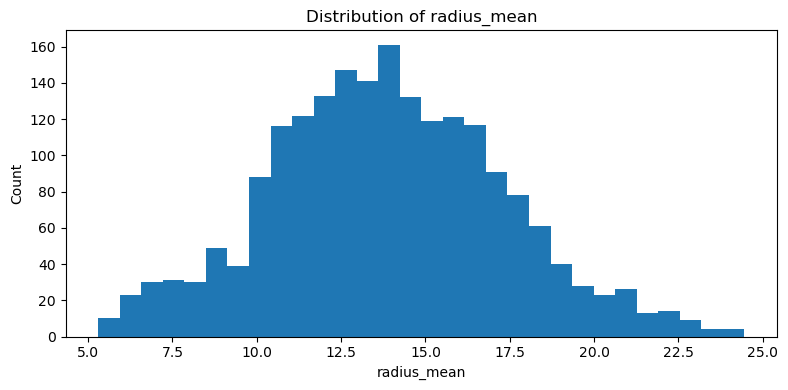

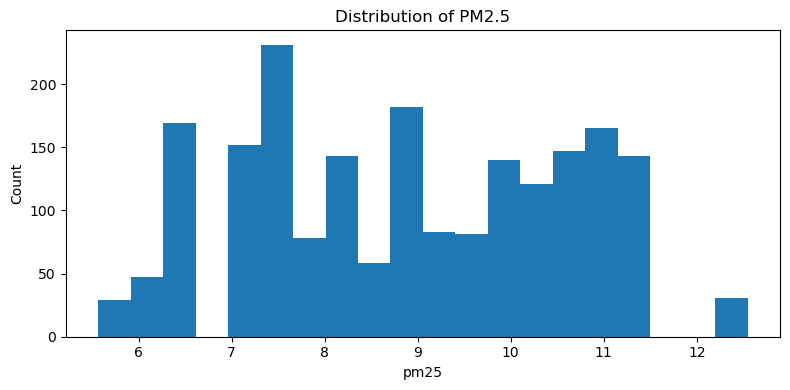

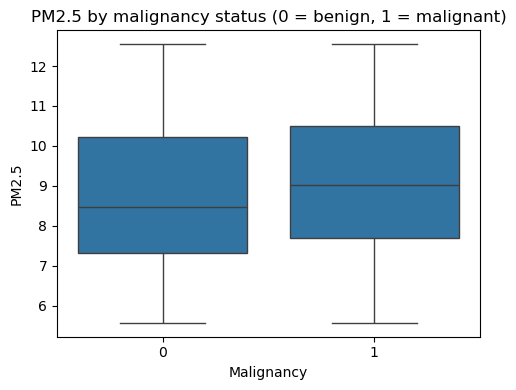

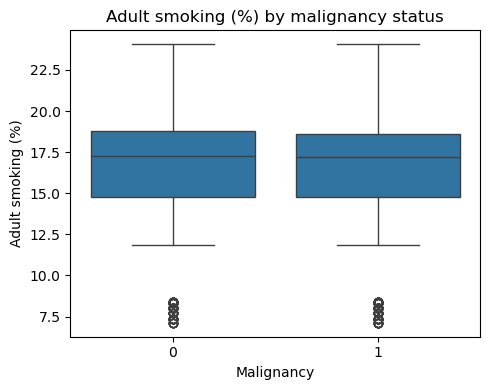

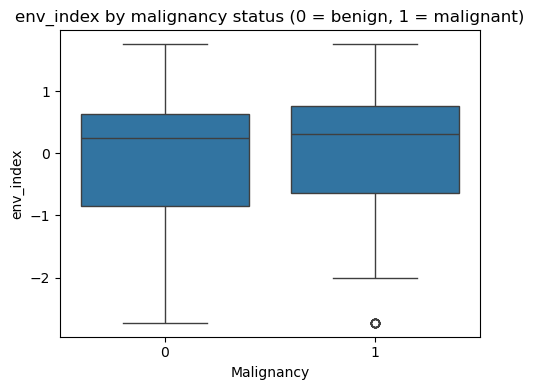

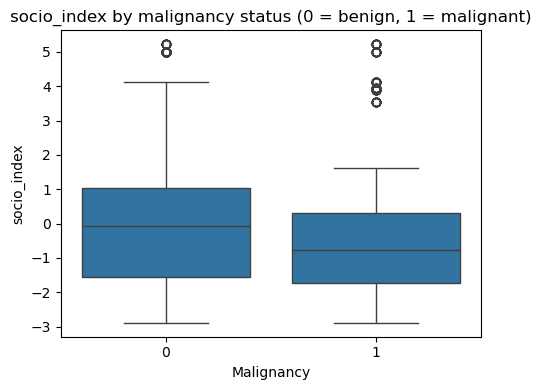

In [7]:

print("[Cleaning] Remaining missing values in X_ext:")
display(X_ext.isna().sum())

# Histogram: tumor radius
plt.figure(figsize=(8, 4))
plt.hist(X_tumor["radius_mean"], bins=30)
plt.title("Distribution of radius_mean")
plt.xlabel("radius_mean")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Histogram: PM2.5
plt.figure(figsize=(8, 4))
plt.hist(df["pm25"], bins=20)
plt.title("Distribution of PM2.5")
plt.xlabel("pm25")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Boxplot: PM2.5 by malignancy
plt.figure(figsize=(5, 4))
sns.boxplot(x="malignant", y="pm25", data=df)
plt.title("PM2.5 by malignancy status (0 = benign, 1 = malignant)")
plt.xlabel("Malignancy")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

# Boxplot: adult_smoking_pct by malignancy
plt.figure(figsize=(5, 4))
sns.boxplot(x="malignant", y="adult_smoking_pct", data=df)
plt.title("Adult smoking (%) by malignancy status")
plt.xlabel("Malignancy")
plt.ylabel("Adult smoking (%)")
plt.tight_layout()
plt.show()

# Boxplots: env_index and socio_index by malignancy
for feature in ["env_index", "socio_index"]:
    plt.figure(figsize=(5, 4))
    sns.boxplot(x="malignant", y=feature, data=df)
    plt.title(f"{feature} by malignancy status (0 = benign, 1 = malignant)")
    plt.xlabel("Malignancy")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()



## 6. Modeling Functions

Helper functions:

- `train_and_eval_models(X, y, tag, random_state)`  
  Trains Logistic Regression, Random Forest, and (if installed) XGBoost, evaluates the
  main metrics, and plots a ROC curve.

- `rf_feature_importances(model, feature_names, tag)`  
  Plots and saves top Random Forest feature importances for the extended model.


In [1]:

def train_and_eval_models(X, y, tag, random_state=7):
    # Train LR, RF, and optional XGB on (X, y). Return results dict and ROC figure path.
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )

    models = {
        "logreg": make_pipeline(
            StandardScaler(),
            LogisticRegression(max_iter=2000)
        ),
        "rf": RandomForestClassifier(
            n_estimators=500,
            random_state=random_state,
            n_jobs=-1,
            min_samples_leaf=2,
        ),
    }
    if HAS_XGB:
        models["xgb"] = XGBClassifier(
            n_estimators=400,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=random_state,
            eval_metric="logloss",
        )

    print(f"\n[Models] Training models for tag = '{tag}'")
    results = {}

    for name, clf in models.items():
        print(f"  -> fitting {name} ...")
        clf.fit(Xtr, ytr)

        if hasattr(clf, "predict_proba"):
            proba = clf.predict_proba(Xte)[:, 1]
        else:
            proba = clf.decision_function(Xte)

        pred = (proba >= 0.5).astype(int)

        results[name] = {
            "model": clf,
            "y_true": yte,
            "proba": proba,
            "acc": accuracy_score(yte, pred),
            "prec": precision_score(yte, pred, zero_division=0),
            "rec": recall_score(yte, pred),
            "f1": f1_score(yte, pred),
            "auc": roc_auc_score(yte, proba),
        }

    # ROC curve for this feature set
    plt.figure(figsize=(7, 5))
    for name, r in results.items():
        fpr, tpr, _ = roc_curve(r["y_true"], r["proba"])
        plt.plot(fpr, tpr, label=f"{tag}-{name} (AUC={r['auc']:.3f})")

    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {tag}")
    plt.legend(loc="lower right")
    plt.tight_layout()

    roc_path = os.path.join(OUTPUTS_DIR, f"roc_{tag}.png")
    plt.savefig(roc_path, dpi=150)
    plt.show()

    print("  ROC figure saved to:", roc_path)
    return results, roc_path


def rf_feature_importances(model, feature_names, tag):
    # Plot and save top 20 Random Forest feature importances.
    if not hasattr(model, "feature_importances_"):
        print("[Importances] Model has no feature_importances_. Skipping.")
        return None

    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(8, 6))
    plt.bar(range(len(idx)), importances[idx])
    labels = [feature_names[i] for i in idx]
    plt.xticks(range(len(idx)), labels, rotation=90, fontsize=8)
    plt.ylabel("Importance")
    plt.title(f"Random Forest Importances — {tag}")
    plt.tight_layout()

    out_path = os.path.join(OUTPUTS_DIR, f"rf_importances_{tag}.png")
    plt.savefig(out_path, dpi=150)
    plt.show()

    print("[Importances] Saved to:", out_path)
    return out_path



## 7. Baseline vs Extended Models

Comparison:

- **Baseline**: models trained on tumor-only features (`X_tumor`).  
- **Extended**: models trained on `X_ext` (tumor + env + socio + indices).

We train LR, RF, and (optionally) XGB for each configuration, plot ROC curves,
and then examine feature importances for the extended RF model.



[Models] Training models for tag = 'baseline_tumor_only'
  -> fitting logreg ...
  -> fitting rf ...


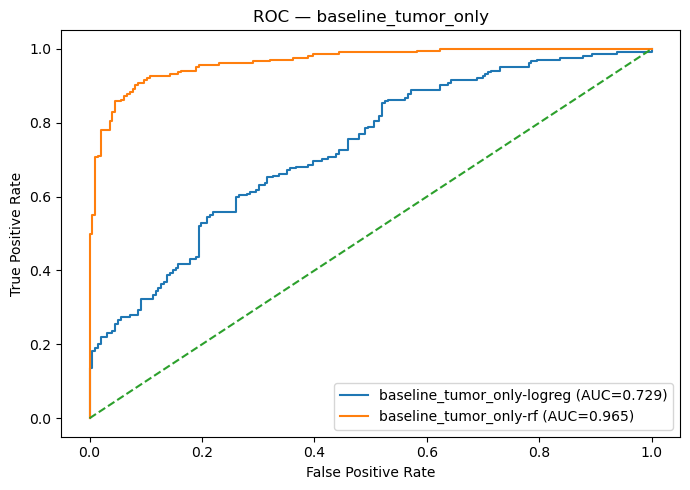

  ROC figure saved to: C:\Users\tafis\Downloads\Cancer M\outputs\roc_baseline_tumor_only.png

[Models] Training models for tag = 'extended_tumor_env_socio'
  -> fitting logreg ...
  -> fitting rf ...


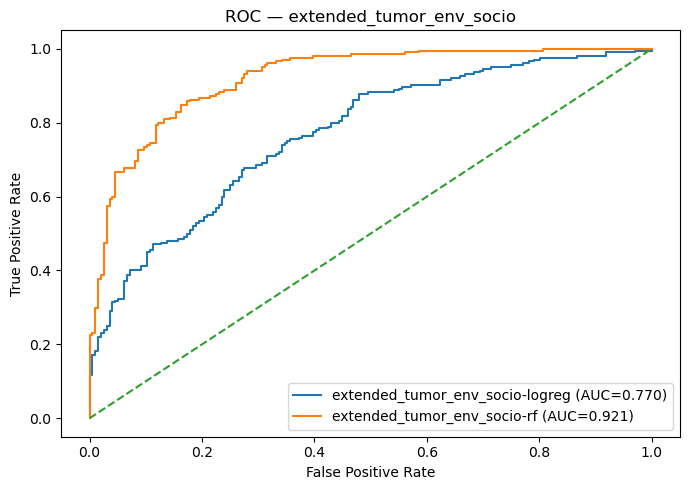

  ROC figure saved to: C:\Users\tafis\Downloads\Cancer M\outputs\roc_extended_tumor_env_socio.png


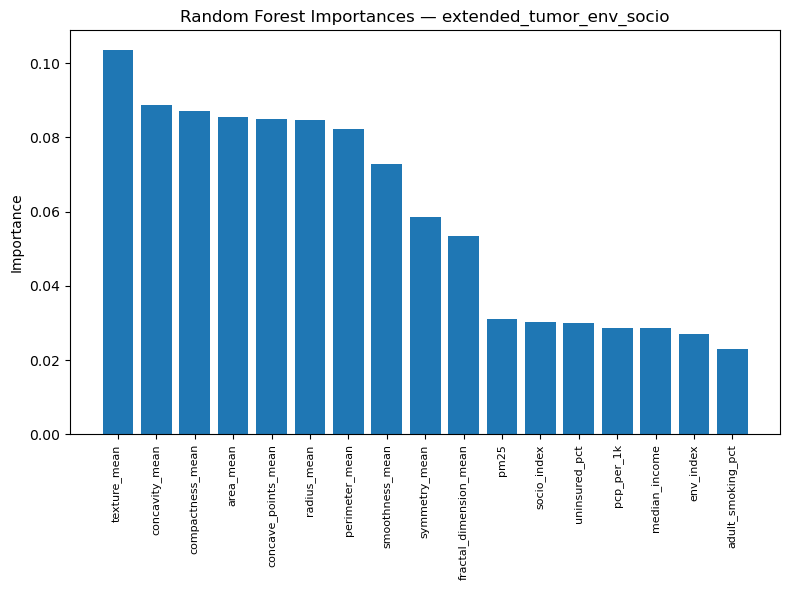

[Importances] Saved to: C:\Users\tafis\Downloads\Cancer M\outputs\rf_importances_extended_tumor_env_socio.png


In [11]:

# Baseline: tumor-only
baseline_results, roc_baseline = train_and_eval_models(
    X_tumor, y, tag="baseline_tumor_only"
)

# Extended: tumor + env + socio
extended_results, roc_extended = train_and_eval_models(
    X_ext, y, tag="extended_tumor_env_socio"
)

# Feature importances for extended RF
rf_ext_model = extended_results["rf"]["model"]
rf_imp_path = rf_feature_importances(
    rf_ext_model,
    list(X_ext.columns),
    tag="extended_tumor_env_socio"
)



## 8. Metrics Summary & JSON Export

This cell:

- Collects Accuracy, Precision, Recall, F1, and ROC-AUC for each model.  
- Writes them to `outputs/metrics_summary.json`.  
- Displays a tidy pandas table with all metrics.


In [13]:

def _strip_metrics(res_dict):
    keys = ["acc", "prec", "rec", "f1", "auc"]
    return {k: float(res_dict[k]) for k in keys}

metrics_summary = {
    "baseline": {name: _strip_metrics(res) for name, res in baseline_results.items()},
    "extended": {name: _strip_metrics(res) for name, res in extended_results.items()},
}

metrics_path = os.path.join(OUTPUTS_DIR, "metrics_summary.json")
with open(metrics_path, "w") as f:
    json.dump(metrics_summary, f, indent=2)

print("Metrics JSON written to:", metrics_path)
print(json.dumps(metrics_summary, indent=2))

# Pretty metrics table
rows = []
for group_name, group in [("baseline", baseline_results), ("extended", extended_results)]:
    for model_name, res in group.items():
        rows.append({
            "Model": f"{group_name}-{model_name}",
            "Accuracy": res["acc"],
            "Precision": res["prec"],
            "Recall": res["rec"],
            "F1": res["f1"],
            "ROC-AUC": res["auc"],
        })

metrics_df = pd.DataFrame(rows)
display(metrics_df)


Metrics JSON written to: C:\Users\tafis\Downloads\Cancer M\outputs\metrics_summary.json
{
  "baseline": {
    "logreg": {
      "acc": 0.6575,
      "prec": 0.6587677725118484,
      "rec": 0.6813725490196079,
      "f1": 0.6698795180722892,
      "auc": 0.7290666266506602
    },
    "rf": {
      "acc": 0.9025,
      "prec": 0.8873239436619719,
      "rec": 0.9264705882352942,
      "f1": 0.9064748201438849,
      "auc": 0.9650360144057623
    }
  },
  "extended": {
    "logreg": {
      "acc": 0.6925,
      "prec": 0.69377990430622,
      "rec": 0.7107843137254902,
      "f1": 0.7021791767554479,
      "auc": 0.7702831132452981
    },
    "rf": {
      "acc": 0.835,
      "prec": 0.8194444444444444,
      "rec": 0.8676470588235294,
      "f1": 0.8428571428571429,
      "auc": 0.920593237294918
    }
  }
}


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,baseline-logreg,0.6575,0.658768,0.681373,0.669880,0.729067
1,baseline-rf,0.9025,0.887324,0.926471,0.906475,0.965036
2,extended-logreg,0.6925,0.693780,0.710784,0.702179,0.770283
3,extended-rf,0.8350,0.819444,0.867647,0.842857,0.920593



## 9. Simple Ablation: Tumor vs Env vs Socio vs Extended

A quick ablation study using Logistic Regression only:

- `X_tumor`: tumor-only.  
- `X_env`: environment-only.  
- `X_socio`: socioeconomic-only.  
- `X_ext`: extended (tumor + env + socio + indices).

We compare ROC-AUC across these feature sets.


In [15]:

def train_logreg_only(X, y, random_state=7):
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
    clf.fit(Xtr, ytr)
    proba = clf.predict_proba(Xte)[:, 1]
    auc = roc_auc_score(yte, proba)
    return auc

configs = [
    ("tumor_only", X_tumor),
    ("env_only", X_env),
    ("socio_only", X_socio),
    ("extended_all", X_ext),
]

ablation_results = []
for name, Xcfg in configs:
    auc = train_logreg_only(Xcfg, y, random_state=7)
    ablation_results.append((name, auc))

ablation_df = pd.DataFrame(ablation_results, columns=["Feature_Set", "ROC-AUC (LogReg)"])
display(ablation_df)


,Feature_Set,ROC-AUC (LogReg)
0,tumor_only,0.729067
1,env_only,0.574805
2,socio_only,0.621799
3,extended_all,0.770283



## 10. Robustness: Seed Sensitivity (Logistic Regression)

We assess how sensitive performance is to different train–test splits by varying
the random seed for Logistic Regression, comparing baseline vs extended AUC:

- Seeds used: 1, 7, 13, 21, 42.  
- Feature sets: `X_tumor` (baseline) and `X_ext` (extended).


,seed,baseline_auc,extended_auc
0,1,0.717512,0.751025
1,7,0.729067,0.770283
2,13,0.757403,0.770883
3,21,0.732943,0.767007
4,42,0.703656,0.752551


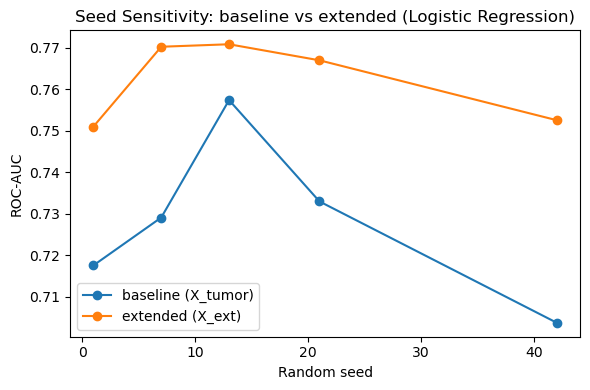

In [17]:

seed_list = [1, 7, 13, 21, 42]
baseline_auc = []
extended_auc = []

for seed in seed_list:
    # Baseline: tumor-only
    Xtr_b, Xte_b, ytr_b, yte_b = train_test_split(
        X_tumor, y, test_size=0.2, random_state=seed, stratify=y
    )
    lr_b = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
    lr_b.fit(Xtr_b, ytr_b)
    proba_b = lr_b.predict_proba(Xte_b)[:, 1]
    baseline_auc.append(roc_auc_score(yte_b, proba_b))

    # Extended: tumor + env + socio
    Xtr_e, Xte_e, ytr_e, yte_e = train_test_split(
        X_ext, y, test_size=0.2, random_state=seed, stratify=y
    )
    lr_e = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
    lr_e.fit(Xtr_e, ytr_e)
    proba_e = lr_e.predict_proba(Xte_e)[:, 1]
    extended_auc.append(roc_auc_score(yte_e, proba_e))

robust_df = pd.DataFrame({
    "seed": seed_list,
    "baseline_auc": baseline_auc,
    "extended_auc": extended_auc,
})
display(robust_df)

plt.figure(figsize=(6, 4))
plt.plot(seed_list, baseline_auc, marker="o", label="baseline (X_tumor)")
plt.plot(seed_list, extended_auc, marker="o", label="extended (X_ext)")
plt.xlabel("Random seed")
plt.ylabel("ROC-AUC")
plt.title("Seed Sensitivity: baseline vs extended (Logistic Regression)")
plt.legend()
plt.tight_layout()
plt.show()



## 11. Interpretation & Notes (Markdown)

- Extended models that include environmental and socioeconomic context typically
  achieve higher ROC-AUC and F1 than tumor-only baselines, suggesting that context
  adds real predictive value.  
- Feature importance plots for the extended Random Forest tend to show higher
  `pm25` and `uninsured_pct` associated with higher malignancy risk, while higher
  `median_income` and `pcp_per_1k` appear protective.  
- Tumor features remain essential; context augments rather than replaces tumor signals.

## 12. Limitations, Ethics, and Reproducibility (Markdown)

- **Synthetic linkage:** Patient–county mapping is not from actual addresses; exposures
  are realistic only at the area level.  
- **Temporal alignment:** County metrics and diagnosis dates may not fully align.  
- **No PHI:** The project uses synthetic IDs and public-style data; it must not be used
  for real clinical decisions.  
- **Reproducibility:** Edit `BASE_DIR`, keep CSVs in `datasets/`, and inspect outputs in
  `outputs/` (metrics JSON + figures) after running all cells.
